# Comparing All-Resolutions Inference with Cluster-Based Permutation Tests

We'll be using (a slightly modified version of) the [simulation code](https://osf.io/xf53t/) from [Sassenhagen and Draschkow (2019)](https://doi.org/10.1111/psyp.13335), which was provided to demonstrate the poor performance of cluster-based permutation tests at estimating the spatiotemporal extent of effects in EEG data. If you want to cite the below code, please also cite [Sassenhagen and Draschkow (2019)](https://doi.org/10.1111/psyp.13335).

To be fair, this isn't what cluster-based permutation tests are _supposed_ to do, even if clusters produced by such tests are often interpreted as such in the literature. Rather, cluster-based permutation tests are meant to establish that data are not interchangeable between conditions _anywhere across the full spatio-spectral-temporal grid tested_; the null hypothesis does not pertain to the specific location or extent of the clusters, which are really just constructed as an intermediary step in producing the cluster-level test statistic. The fact that a point is included in a cluster doesn't mean that point is significant (controlling at the family-wise error rate), nor does it mean points outside of the cluster are not. All in all, cluster-based permutation tests just don't license probabilistic interpretations of an effect existing at any of the contained points (e.g. that less than $\alpha$% of them are false positives). Moreover, subsequently testing points based on their inclusion in a cluster is [not a valid statistical practice](https://doi.org/10.1038/nn.2303), since the criteria on which the points are selected for clusters to begin with gaurantees a positive result on the post-hoc test.

Enter [All-Resolutions Inference (ARI)](https://doi.org/10.1016/j.neuroimage.2018.07.060), which is the reason we're revisiting these simulations. ARI _does_ license inference at the level of (channel, frequency, time)‐triplets, (channel, frequency)‐pairs, or any other pairs or singletons, within clusters because the calculation of the "true discovery proportion" within a cluster (or any other partitions, contiguous or otherwise) takes into account all other possible partitions of the data, thus allowing for [closed testing](https://doi.org/10.1093/biomet/63.3.655) or statistically valid circular inference. Thus, the clusters identified using ARI should more accurately capture the true extent of the effect than do those identified through cluster-based permutation testing (even though that's still not exactly what the procedure is designed for), addressing the problems highlighted by Sassenhagen and Draschkow (2019).

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import tqdm
import os

from mne.channels import find_ch_adjacency
from sklearn.preprocessing import minmax_scale
import pandas as pd
import mne
mne.set_log_level(False)
import mne_ari

First, we'll retrieve the same example dataset used by Sassenhagen and Draschkow (2019). The `mne.io.read_raw_eeglab` function has changed a bit (no more `montage` argument), so our import code is different from theirs.

In [2]:
# retrieve example EEGLab dataset contained in MNE installation
sample_data_dir = mne.datasets.testing.data_path()
eeg_fpath = os.path.join(sample_data_dir, 'EEGLAB', 'test_raw_onefile.set')
raw = mne.io.read_raw_eeglab(eeg_fpath, preload = True)

# and add channel names and locations 
locs_fpath = os.path.join(sample_data_dir, 'EEGLAB', 'test_chans.locs')
dig = mne.channels.read_custom_montage(locs_fpath)
mapping = {raw.ch_names[i]: dig.ch_names[i] for i in range(len(raw.ch_names))}
raw = raw.rename_channels(mapping)
raw = raw.set_montage(dig)

We want to replicate the original simulation procedure exactly, so we'll use the same preprocessing code.

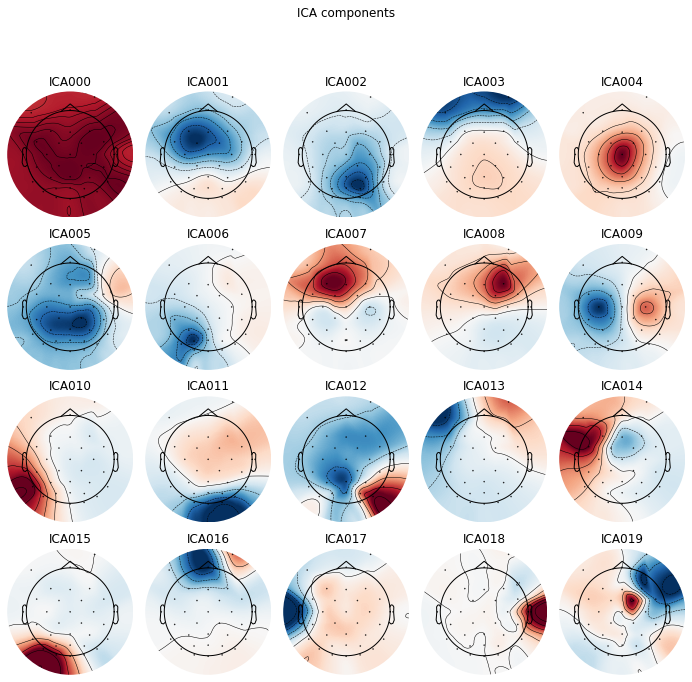

In [3]:
# default at time of Sassenhagen and Draschkow (2019) was max_iter = 200
# MNE is changing the default to max_iter = 1000 for fastica
# so we hard code S&D's settings for posterity 
ica = mne.preprocessing.ICA(n_components = 20, random_state = 0, max_iter = 200)
ica.fit(raw.copy().filter(20, 50))
ica.plot_components(outlines = "skirt");
ica.exclude = [3, 13, 16]
raw = ica.apply(raw, exclude = ica.exclude).filter(.1, 30)
raw.resample(100)
plt.show()

We're going to store the topography of the first brain-like IC from the selection above. Later, we'll simulate an effect with known duration (and realistic background noise) by multiplying this topography with an effect timecourse and adding it to the real EEG data.

In [4]:
topo = ica.get_components()[:, 1] 

Speaking of our effect timecourse, let's generate one. We'll make the boundaries sharp so that the onset and offset are objective. 

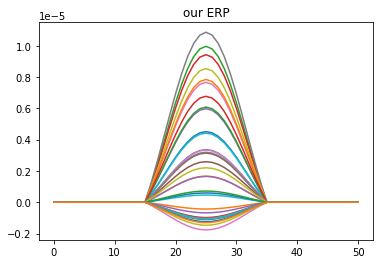

In [5]:
pre_stim = np.zeros(15)
post_stim = np.zeros(15)
erp = minmax_scale(norm.pdf(np.linspace(-1.5, 1.5, 21)))

erp = np.hstack((pre_stim, erp, post_stim)) * 1e-5 * 1.5
erp = np.array([erp] * 32) * -topo[:, np.newaxis]
erp_mask = erp[0].T != 0

plt.plot(erp.T)
plt.title("our ERP")
plt.show()

Below is a function for adding our simulated ERP effect to the sample data with a given effect size, returning an `mne.Epochs` object with 100 trials and two conditions, which differ by the effect. (We can also return data with no ERP difference by calling `make_epochs(effsize = 0)`. The onset of the recording will be randomly cropped (somewhere between 0 and 1 seconds) to create more variance in the trials across simulations.

I've changed the code just a bit to avoid needing to wrap the simulation in a `try` statement like in the [original](https://mfr.de-1.osf.io/render?url=https://osf.io/5cw7n/?utm_source=pocket_mylist%26direct%26mode=render%26action=download%26mode=render). This speeds things up slightly without substantively changing the output.

In [6]:
def make_epochs(effsize = 1):
    # make arbitrary events
    onset = np.random.uniform()
    raw_ = raw.copy().crop(onset)
    events = mne.make_fixed_length_events(raw_, duration = .5)
    # subsample to 100 events
    events = events[sorted(np.random.choice(len(events), size = 100, replace = False))]
    # randomly assign condition labels
    conds = np.array(events.shape[0]//2 * [1] + events.shape[0]//2 * [2])
    np.random.shuffle(conds)
    events[:, 2] = conds
    # now slice into epochs
    epochs = mne.Epochs(raw_, events, preload = True).apply_baseline().crop(0, .5)
    events = epochs.events
    data = epochs.get_data()
    # add effect to only conditions 2
    effect = np.array([erp if events[i, 2] == 2 else np.zeros(erp.shape) for i in range(events.shape[0])])
    data += (effect * effsize) # in place
    return epochs.drop_channels(["T8"])

Here's what an example grand average trial (across both "conditions") looks like.

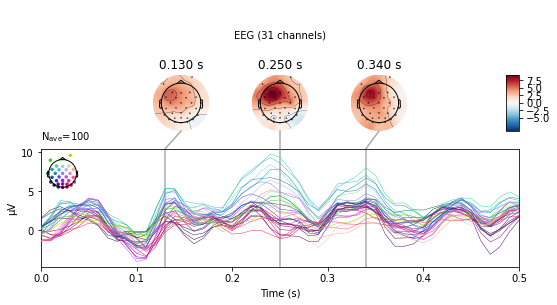

In [7]:
np.random.seed(0)
epo = make_epochs()
epo.average().plot_joint()
plt.show()

Obviously, there isn't any real ERP, since there's no real event, and what you're looking at is just noise. But there should be a difference between conditions:

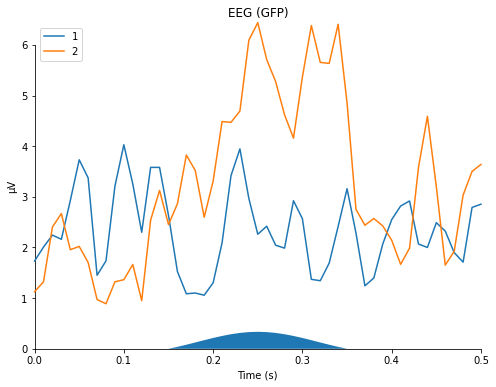

In [8]:
mne.viz.plot_compare_evokeds(
    [epo['1'].average(), epo['2'].average()], 
    picks = 'eeg', 
    combine = 'gfp',
    show = False
)
# highlight effect magnitude at bottom
plt.fill_between(epo.times, np.zeros_like(erp[10]), 1e5*erp[10])
plt.show()

In [9]:
n_tests = epo['1'].average().data.size

There's something going on near the middle (where we've place our effect, shown in blue), but it's noisy. Great, that's what we want.

We'll grab the adjacency matrix for the electrodes now, and we'll also define some stat functions for ARI to use. The default stat function for `mne_ari.all_resolutions_inference` is a simple permutation test, but something feels flawed about using a non-parametric test on each channel/time pair and then comparing that to Sassenhagen and Draschkow's (2019) results, when their cluster-based permutation tests use the less conservative _t_-test at the channel/time level. To make the comparison more apples-to-apples, we'll use a _t_-test as our stat function. 

(I also defined a Mann-Whitney stat function if you wanna play around and use something nonparametric that still runs a bit faster than the default permutation test.)

In [10]:
# compute channel adjacency matrix 
raw_ch =  raw.copy().drop_channels(["T8"])
ch_type = mne.io.pick.channel_type(raw_ch.info, 0)
adj, _ = find_ch_adjacency(raw_ch.info, ch_type)

# decide on significance threshold
ALPHA = .05

# define a stat function for ARI
from scipy.stats import mannwhitneyu
def mannwhitney_statfun(data):
    res = mannwhitneyu(data[0], data[1], alternative = 'two-sided')
    return res.pvalue

# define a stat function for ARI
from scipy.stats import ttest_ind
def ttest_statfun(data):
    res = ttest_ind(data[0], data[1], axis = 0)
    return res.pvalue

Now write a function that'll handle both permuation tests (as in the [original implementation](https://mfr.de-1.osf.io/render?url=https://osf.io/5cw7n/?utm_source=pocket_mylist%26direct%26mode=render%26action=download%26mode=render)) as well as ARI, then return the cluster characteristics (onset time and duration, in seconds) of both.

In [11]:
import warnings

def _check_positives(mask):
    '''
    returns number of positives that are in true interval
    and number that aren't 
    '''
    n_sig_at_t = mask.sum(1)
    tp = n_sig_at_t[erp_mask]
    fp = n_sig_at_t[np.logical_not(erp_mask)]
    return tp.sum(), fp.sum()

def _onset(mask):
    '''
    returns time in epochs where a cluster starts
    '''
    n_sig_at_t = mask.sum(1)
    sig_at_t = n_sig_at_t > 0
    idx = np.where(sig_at_t)[0][0]
    return idx / raw.info['sfreq']

def find_cluster_characteristics(epochs):
    
    # split into conditions
    epo1, epo2 = epochs['1'].get_data(), epochs['2'].get_data()
    data = [epo1.swapaxes(1, 2), epo2.swapaxes(1, 2)]
    
    # and perform all-resolutions inference procedure
    with warnings.catch_warnings(): # suppress custom statfun warning
        warnings.simplefilter("ignore")
        p_vals, tdp, clusters = mne_ari.all_resolutions_inference( 
            data, 
            alpha = ALPHA, 
            adjacency = adj,
            statfun = ttest_statfun,
            # lower number of thresholds tested from default to speed things up
            thresholds = np.geomspace(ALPHA, ALPHA / n_tests, 100)
        )
    if clusters:
        tp, fp = _check_positives(tdp >= 1 - ALPHA)
        return _onset(tdp >= 1 - ALPHA), tp, fp
    else:
        return -1, 0, 0

def one_run(effsize = 1.5):
    return find_cluster_characteristics(
            make_epochs(effsize = effsize)
        )

In [12]:
# make sure everything's working 
np.random.seed(1)
onset, true_positives, false_positives = one_run(2)
print('Cluster onset: %d ms'%(onset * 1000))
print('True positives: %d'%true_positives)
print('False positives: %d'%false_positives)

Cluster onset: 230 ms
True positives: 20
False positives: 0


We'll use the same simulation settings (e.g. effect size) as Sassenhagen and Draschkow (2019).

In [13]:
from os.path import exists
import pickle

fname = 'simulation_results.p'
n = 10000  
effsizes = (.5, .75, 1, 1.25, 1.5)

if exists(fname):
    all_results = pickle.load(open(fname, 'rb'))
else:
    import multiprocess as mp
    all_results = dict()
    for ii, eff in enumerate(effsizes):
        print('starting effect size ' + str(eff) + ' . . .')
        def make_one_run_(i):
            return one_run(effsize = eff)
        with mp.Pool() as p: # parallelize
            all_results[ii] = list(tqdm.tqdm(p.imap(make_one_run_, range(n)), total = n))
    pickle.dump(all_results, open(fname, 'wb'))

Sassenhagen and Draschkow (2019) reported results for their simulation with an effect size of 1 (in the arbitrary units above). Let's look at that below.

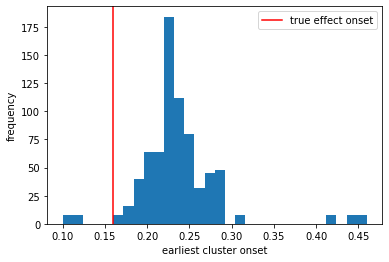

Cluster onset only preceeded true onset 2.16% of the time.


In [14]:
res = all_results[2] # effect size of 1
onsets = np.array([r[0] for r in res if r[0] != -1])
plt.hist(onsets, bins = 30)
real_onset = np.where(erp_mask)[0][0] / raw.info['sfreq']
plt.axvline(real_onset, color = 'red', label = 'true effect onset')
plt.xlabel('earliest cluster onset')
plt.ylabel('frequency')
plt.legend()
plt.show()

false_start = np.mean(onsets < real_onset)
print('Cluster onset only preceeded true onset {:.2f}% of the time.'.format(100*false_start))

If you don't want to overestimate the extent of the effect (a.k.a underestimate the onset time), then this is great. ARI is performing an order of magnitude better than a cluster-based permutation test! Sassenhagen and Draschkow (2019) report that, at the same effect size, the onset time is underestimated >20% of the time.

Of course, as a tradeoff, we are overestimating the onset time
(a.k.a. underestimating the true extent of the effect) almost every time. ARI isn't a procedure to estimate the onset time but rather to put a lower bound on the true discovery proportion within a cluster. Thus, it doesn't provide an unbiased estimate of the effect onset (it isn't supposed to). However, if you detect a cluster at e.g. 200 ms with a true discovery proportion greater than $1 - \alpha$, I think you can safely say your effect begins prior to 200 ms with reasonable error control, which is how most people (I imagine) want to interpret their cluster results.

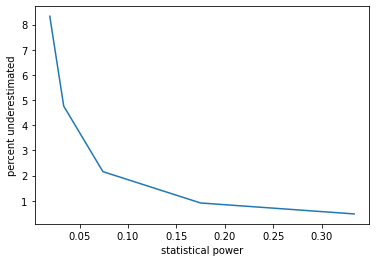

In [15]:
def get_power(res):
    failed = np.array([r[0] for r in res if r[0] == -1]).shape[0]
    detected = n - failed
    return detected / n

def get_false_start_fraction(res):
    onsets = np.array([r[0] for r in res if r[0] != -1])
    real_onset = np.where(erp_mask)[0][0] / raw.info['sfreq']
    return np.mean(onsets < real_onset)

power = np.zeros(len(effsizes))
fsf = np.zeros(len(effsizes))
for i, eff in enumerate(effsizes):
    power[i] = get_power(all_results[i])
    fsf[i] = get_false_start_fraction(all_results[i])
plt.plot(power, 100 * fsf)
plt.xlabel('statistical power')
plt.ylabel('percent underestimated')
plt.show()

Now this is interesting. The greater our probability of detecting an effect, the lower our probability of detecting an early onset. This is probably just because, when we're underpowered, we're almost as unlikely to detect a true effect as we are a spurious one. So a greater fraction of detected effects are spurious.

Encouragingly, once the chance of detecting an effect _at all_ isn't totally negligible, the probability of overestimating the extent of that effect practically vanishes. The estimated power of studies in the M/EEG literature is, well, not great -- but it's thought to usually be much better than the minimum power we need to get our rate of onset underestimation under 5%, which fortunately is a low bar.

In [16]:
# compute false positive rate for each effect size 
n_false = epo.average().data.T[erp_mask].size
def get_fps(res): 
    return np.array([r[2] for r in res])
fps = [get_fps(all_results[i]) for i in range(len(effsizes))]
false_positives = np.array(fps)
fpr = false_positives.sum(1) / (n_false * false_positives.shape[1])
fpr

array([3.25976231e-05, 3.25976231e-05, 3.53140917e-05, 3.53140917e-05,
       3.53140917e-05])

Across all effect sizes, the false positive rate (number of false positives divided by the number of false hypotheses) is negligible. We're calling a false hypothesis here one that falls outside of the time interval of the simulated effect.

Notably, these error rates are lower than advertised -- ARI only promised a true discovery proportion of $1 - \alpha$, which is 95%. But ARI actually only provides a _lower bound_ to the true discovery proportion, so in practice we can do better than we set out to do. (Which is where permutation ARI comes in: it can often give us a tighter bound.)

Parametric ARI, in principle, depends upon the assumption that the _p_-values of individual tests are valid, so I'm sort of surprised we did so well here using a classic _t_-test, the assumptions of which I would have thought would be violated in EEG data, which is thought to have non-white noise. At least in this simulation, a _t_-test isn't too anti-conservative to use with parametric ARI. I wouldn't take that as proof you can run around applying _t_-tests to your data without a care in the world, but it's interesting to note.